В **этом ноутбуке** анализируется, как велопрокатом пользуются владельцы различных абонементов.

In [0]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import scipy.stats as sps
from tqdm import tqdm
import datetime
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt

import plotly.graph_objects as go
import plotly.express as px
import plotly.offline


from mpl_toolkits.basemap import Basemap

### 0. Загрузка данных

In [0]:
trips = pd.read_csv('cycle-share-dataset/trip.csv', error_bad_lines=False,
                   parse_dates=[1, 2])

b'Skipping line 50794: expected 12 fields, saw 20\n'


label encoding и парсинг временных признаков

In [0]:
le = preprocessing.LabelEncoder()
le_trips = trips.copy()
le_trips.bikeid = le.fit_transform(le_trips.bikeid)
le_trips.from_station_id = le.fit_transform(le_trips.from_station_id)
le_trips.to_station_id = le.transform(le_trips.to_station_id)
le_trips.usertype = (le_trips.usertype.values == 'Member').astype(int)
le_trips.gender = (le_trips.gender == 'Male').astype(int)

le_trips['start_year'] = le_trips['starttime'].dt.year
le_trips['start_month'] = le_trips['starttime'].dt.month
le_trips['start_day'] = le_trips['starttime'].dt.day
le_trips['start_date'] = le_trips['starttime'].dt.date
le_trips['start_time'] = le_trips['starttime'].dt.time
le_trips['start_weekday'] = le_trips['starttime'].dt.dayofweek

le_trips['stop_year'] = le_trips['stoptime'].dt.year
le_trips['stop_month'] = le_trips['stoptime'].dt.month
le_trips['stop_day'] = le_trips['stoptime'].dt.day
le_trips['stop_date'] = le_trips['stoptime'].dt.date

le_trips['stop_time'] = le_trips['stoptime'].dt.time
le_trips['stop_weekday'] = le_trips['stoptime'].dt.dayofweek

le_trips.fillna(-1, inplace=True)

In [0]:
le_trips.head()

,trip_id,starttime,stoptime,bikeid,tripduration,from_station_name,to_station_name,from_station_id,to_station_id,usertype,...,start_day,start_date,start_time,start_weekday,stop_year,stop_month,stop_day,stop_date,stop_time,stop_weekday
0,431,2014-10-13 10:31:00,2014-10-13 10:48:00,289,985.935,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,8,31,1,...,13,2014-10-13,10:31:00,0,2014,10,13,2014-10-13,10:48:00,0
1,432,2014-10-13 10:32:00,2014-10-13 10:48:00,186,926.375,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,8,31,1,...,13,2014-10-13,10:32:00,0,2014,10,13,2014-10-13,10:48:00,0
2,433,2014-10-13 10:33:00,2014-10-13 10:48:00,477,883.831,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,8,31,1,...,13,2014-10-13,10:33:00,0,2014,10,13,2014-10-13,10:48:00,0
3,434,2014-10-13 10:34:00,2014-10-13 10:48:00,324,865.937,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,8,31,1,...,13,2014-10-13,10:34:00,0,2014,10,13,2014-10-13,10:48:00,0
4,435,2014-10-13 10:34:00,2014-10-13 10:49:00,193,923.923,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,8,31,1,...,13,2014-10-13,10:34:00,0,2014,10,13,2014-10-13,10:49:00,0


In [0]:
le_trips.columns

Index(['trip_id', 'starttime', 'stoptime', 'bikeid', 'tripduration',
       'from_station_name', 'to_station_name', 'from_station_id',
       'to_station_id', 'usertype', 'gender', 'birthyear', 'start_year',
       'start_month', 'start_day', 'start_date', 'start_time', 'start_weekday',
       'stop_year', 'stop_month', 'stop_day', 'stop_date', 'stop_time',
       'stop_weekday'],
      dtype='object')

### 1. Анализ зависимостей

Посмотрим, как разные признаки влияют на наличие абонемента. 

Анализ будем осуществлять с помощью двух критериев:

1) Для категориальных признаков классический хи-квадрат.

2) Для вещественных признаков критерий Манна-Уитни: в зависимости от наличия абонемента будем получать две вещественные выборки и проверять гипотезу о равенстве их распределений. В случае отвержения гипотезы, делаем вывод, что признак влияет на наличие абонемента.

**Категориальные признаки:**

In [0]:
pvalues = []

cat_features = ['from_station_id', 'to_station_id', 'gender',
                'birthyear',
                'start_year', 'start_month', 'start_weekday']

for feat in cat_features:
    print(f'Признак {feat}')
    
    obs = pd.crosstab(le_trips[feat],
                      le_trips['usertype'])
    chi2, p, dof, expected = sps.chi2_contingency(obs)
    if (expected < 5).mean() < 0.2:
        print(f'p-value: {p}')
        pvalues.append(p)
    else:
        print('Критерий неприменим')
        pvalues.append(-1)
    print()

Признак from_station_id
p-value: 0.0

Признак to_station_id
p-value: 0.0

Признак gender
p-value: 0.0

Признак birthyear
p-value: 0.0

Признак start_year
p-value: 1.4820725743292082e-296

Признак start_month
p-value: 0.0

Признак start_weekday
p-value: 0.0



**Вещественные признаки**

Вещественный признак здесь только один - tripduration.

In [0]:
st, p = sps.mannwhitneyu(le_trips[le_trips.usertype == 1]['tripduration'],
                         le_trips[le_trips.usertype == 0]['tripduration'])

pvalues.append(p)

**Итог:**

In [0]:
multipletests(pvalues)

(array([ True,  True,  True,  True,  True,  True,  True,  True]),
 array([0., 0., 0., 0., 0., 0., 0., 0.]),
 0.006391150954545011,
 0.00625)

Для всех признаков гипотеза о независимости отверглась, а значит все они влияют на наличие абонемента.

### 2. Абонементы у участников групповых поездок

In [0]:
group_trips = pd.read_csv('cycle-share-dataset/trips_w_groups.csv')
group_trips = group_trips.drop(columns=['Unnamed: 0'])

group_count = pd.DataFrame(group_trips.groupby(by = 'group_id').
                           count()['trip_id'])

group_count.columns = ['members_num']
group_count.reset_index(inplace=True)

group_trips = group_trips.merge(group_count,
                                how='left', on='group_id')

In [43]:
np.unique(group_trips.members_num)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 12, 14, 16, 20, 24])

In [0]:
trips = group_trips.copy()
single_trips = group_trips[group_trips.members_num == 1]
group_trips = group_trips[group_trips.members_num > 1]

Посмотрим на распределение наличия абонементов у тех, кто катается один и у тех, кто катается группой.

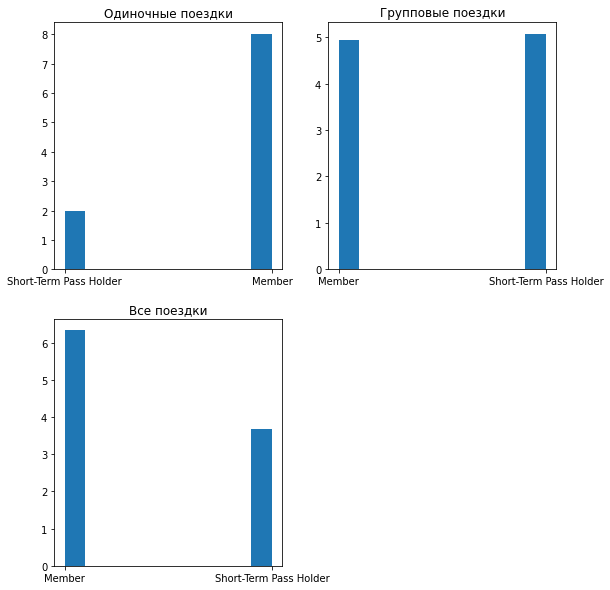

In [45]:
plt.figure(figsize=(9, 10))

plt.subplot(221)
plt.title('Одиночные поездки')
plt.hist(single_trips.usertype.values, density=True)

plt.subplot(222)
plt.title('Групповые поездки')
plt.hist(group_trips.usertype.values, density=True)

plt.subplot(223)
plt.title('Все поездки')
plt.hist(trips.usertype.values, density=True)

plt.show()

**Наблюдение:** удивительно, но больше половины участников групповых поездок не владеют абонементами, в то время как те, кто катаются по одиночке, в подавляющем большинстве владеют абонементами. 

При этом в ноутбуке по исследованию групповых поездок мы выяснили, что они составляют большую долю от всех поездок, поэтому можно посоветовать компании придумать способ рекламы абонементов участникам групповых поездок, например, какие-нибудь скидки по акции "приведи друга".  

### 3. Визуализация маршрутов владельцев абонементов

Посмотрим, по каким маршрутам обычно катаются люди без абоменементов и люди с абонементами.

In [0]:
stations = pd.read_csv('cycle-share-dataset/station.csv')

In [0]:
def most_popular(trip):
    d = {}
    
    for route in trip.values:
        from_to = (route[7], route[8])
        if from_to in d:
            d[from_to] += 1
        else:
            d[from_to] = 1
        
    d = {k: v for k, v in sorted(d.items(), key=lambda item: item[1])[::-1]}
    
    return d


def plot_popular(popular_dict, n=10):
    px.set_mapbox_access_token(open("public_key").read())
    fig = px.scatter_mapbox(stations, lat="lat", lon="long",
                            zoom=11)
    top = list(popular_dict.keys())[:n]

    for route in top:
        st_from = route[0]
        st_to = route[1]
        from_lon = stations[stations.station_id == st_from].long.values[0]
        from_lat = stations[stations.station_id == st_from].lat.values[0]
        to_lon = stations[stations.station_id == st_to].long.values[0]
        to_lat = stations[stations.station_id == st_to].lat.values[0]

        fig.add_trace(go.Scattermapbox(mode = "markers+lines",
                                       lon = [from_lon, to_lon],
                                       lat = [from_lat, to_lat],
                                       marker = {'size': 10}))
        
    fig.show()

In [48]:
member_popular = most_popular(trips[trips.usertype == 'Member'])
plot_popular(member_popular, 10)

**Наблюдение:** владельцы абонементов часто катаются и в "деловой", и в "развлекательной" частях города. 

In [49]:
not_member_popular = most_popular(trips[trips.usertype != 'Member'])
plot_popular(not_member_popular, 10)

**Наблюдение:** многие, кто не владеет абонементом, оставляют велосипед на той же станции, с которой его берут (точки, выделенные цветом на карте). Также, в отличие от поездок с абонементами, здесь можно заметить активность в районе университета. Возможно, стоит провести отдельную рекламную кампанию на станциях этого района.